In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *
from fastai.vision import *
import fastai.distributed
from pathlib import Path
import pdb
import re
import seaborn as sns
from IPython.display import SVG, display
from wand.image import Image as WImage
import wand
import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
# os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
# enter your path here
path = Path("../google-fonts-data")

In [4]:
out = []
for file in progress_bar(path.glob("**/*.svg"),total=113646):
    try:
        s = file.open().read()
        match = re.match(".*viewBox=\"0 0 (\d+) (\d+)\".*<path.*d=\"([^\"]*)\".*",s,flags=re.DOTALL)
        match2 = re.match(".*<g transform=\"matrix\(1 0 0 -1 0 (\d+)\)\">.*",s,flags=re.DOTALL)
        xform = 0
        if match2:
            xform = float(match2.group(1))
        out.append({"file": file, "path": match.group(3), "box_x": float(match.group(1)), "box_y": float(match.group(2)),"xform": xform})
    except:
        pass

In [5]:
svgDF = pd.DataFrame(out)
svgDF["png"] = svgDF.file.apply(lambda f: "/".join(f.parts[:-2]) + "/png/" + f.name[:-3] + "png")
exists = svgDF.png.apply(lambda f: Path(f).exists())
svgDF["label"] = svgDF.file.apply(lambda f: f.name[:-4])
svgDF["font"] = svgDF.file.apply(lambda f: f.parts[4])
svgDF = svgDF[exists]
svgDF.head()

,box_x,box_y,file,path,xform,png,label,font
0,535.0,1000.0,../google-fonts-data/italic/SANS_SERIF/asap/70...,M32 34q0 10 1 16l2 17q3 27 11.5 38.5t24.5 11.5...,800.0,../google-fonts-data/italic/SANS_SERIF/asap/70...,one,asap
1,843.0,1000.0,../google-fonts-data/italic/SANS_SERIF/asap/70...,M57 6.5q-13 8.5 -11 28.5l66 635q3 32 63 32h52q...,800.0,../google-fonts-data/italic/SANS_SERIF/asap/70...,$M,asap
2,489.0,1000.0,../google-fonts-data/italic/SANS_SERIF/asap/70...,M15.5 24.5q-8.5 24.5 -8.5 48.5q0 15 8 24l257 3...,800.0,../google-fonts-data/italic/SANS_SERIF/asap/70...,z,asap
3,731.0,1000.0,../google-fonts-data/italic/SANS_SERIF/asap/70...,M493.5 -105.5q-133.5 56.5 -258.5 112.5q-97 44 ...,800.0,../google-fonts-data/italic/SANS_SERIF/asap/70...,$Q,asap
4,549.0,1000.0,../google-fonts-data/italic/SANS_SERIF/asap/70...,M174 35l56 534h-158q-14 0 -20.5 9.5t-6.5 31.5q...,800.0,../google-fonts-data/italic/SANS_SERIF/asap/70...,$T,asap


In [6]:
svgDF.to_pickle("svgdf.pkl")

In [4]:
svgDF = pickle.load(Path("svgdf.pkl").open("rb"))

In [5]:
def render_path(path,bbox_x,bbox_y):
    bbox_x,bbox_y = int(bbox_x),int(bbox_y)
    st = f'<svg viewBox="0 0 {bbox_x} {bbox_y}" xmlns="http://www.w3.org/2000/svg"><path d="{path}"/></svg>'
#     img = WImage(blob=str.encode(st),format="svg",width=128,height=128)
    return st

In [6]:
def render_path_wand(path,bbox_x,bbox_y):
    bbox_x,bbox_y = int(bbox_x),int(bbox_y)
    st = f'<svg viewBox="0 0 {bbox_x} {bbox_y}" xmlns="http://www.w3.org/2000/svg"><path d="{path}"/></svg>'
    img = WImage(blob=str.encode(st),format="svg",width=64,height=64)
    return img

In [7]:
img = render_path_wand(svgDF.iloc[0].path,500,500)

In [8]:
img.size

(64, 64)

In [9]:
def wand_to_tensor(wimage):
    wimage.depth = 8
    wimage.background_color = wand.color.Color("white")
    wimage.alpha_channel = "remove"
    blob = wimage.make_blob(format="RGB")
    pixels = []
    for cursor in range(0,64*64*3,3):
        pixels.append((blob[cursor],
                       blob[cursor + 1],
                       blob[cursor + 2]))
    return torch.tensor(pixels).view(64,64,3).float().permute(2,0,1)[0] / 255.0

In [10]:
a = wand_to_tensor(render_path_wand(svgDF.iloc[0].path,500,500))

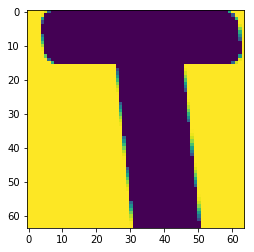

In [11]:
plt.imshow(a)

In [12]:
tool_dict = {"P": [], "M": ["x","y"], "m": ["x","y"], "L": ["x","y"], "l": ["x","y"], "H": ["x"], "h": ["x"], 
             "V": ["y"], "v": ["y"], "C": ["x","y","x","y","x","y"], "c": ["x","y","x","y","x","y"], "S": ["x","y","x","y"], 
             "s": ["x","y","x","y"], "Q": ["x","y","x","y"], "q": ["x","y","x","y"], "T": ["x","y"], "t": ["x","y"],
             "A": ["x","y","","","","x","y"], "a": ["x","y","","","","x","y"], "Z": [], "z": [], "START": [], "END": [], "PAD": []}


class TokenizeSVGProcessor(PreProcessor):
    
    def tokenize(self,path,box_x,box_y,xform,label):
        out = []
        for match in re.findall("([MmLlHhVvCcSsQqTtAaZz])([0-9\.\-\s]*)",path):
            token, pen = match
            td = tool_dict[token]
            xs = []
            for coord,x in zip(td,re.findall("((\-{0,1}\.[0-9]+)|(\-{0,1}[0-9]+\.{0,1}[0-9]*))\s*",pen)):
                x = x[0]
                if coord == "x" and token.isupper():
                    xs.append((float(x) + (box_y - box_x) / 2.0)/float(box_y))
                elif coord == "x":
                    xs.append(float(x)/float(box_y))
                elif coord == "y" and token.isupper():
                    value = (float(xform)-float(x))/float(box_y)
                    xs.append(value)
                elif coord == "y" and xform > 0:
                    value = -float(x)/float(box_y)
                    xs.append(value)
                else:
                    xs.append(float(x))
            assert len(td) == 0 or (len(xs) % len(td) == 0)
            if len(td) == 0:
                out.append((token,[-2.0]*4))
            else:
                for i in range(0,len(xs),len(td)):
                    s = xs[i:i+len(td)]
                    if token == "h":
                        s = [s[0], 0]
                        token = "l"
                    elif token == "v":
                        s = [0, s[0]]
                        token = "l"
                    if len(s) < 4: s += [-2.0] * (4-len(s))
                    out.append((token,s))
        return out,label
    
    def process(self, ds):
        ds.items = array([self.process_one(item) for item in ds.items])

    def process_one(self, item):
        return self.tokenize(*item)
    
class NumericalizeSVGProcessor(PreProcessor):
    def process_one(self,item):
        item,label = item
        return [(self.stoi["START"],[-2.0]*4)
               ] + [(self.stoi[t],n) for t,n in item] + [(self.stoi["END"],[-2.0]*4)],label
            
    def process(self,ds):
        if not hasattr(self,"vocab"):
            vocab = ["PAD"] + list("Mqlthzv") + ["START","END"]
            stoi = {s:i for i,s in enumerate(vocab)}
            self.vocab = ds.vocab = vocab
            self.stoi = ds.stoi = stoi
        super().process(ds)

In [13]:
class SVGList(ItemList):
    _processor = [TokenizeSVGProcessor,NumericalizeSVGProcessor]
    
    def get(self, i):
        item = self.items[i]
        item,label = item
        return [t[0] for t in item], np.stack([t[1] for t in item]), label

In [14]:
def npad_collate(samples:BatchSamples, pad_idx:int=0) -> Tuple[LongTensor, LongTensor]:
    samples = to_data(samples)
    max_len = max([len(s[1][0]) for s in samples])
    res_tokens = torch.zeros(len(samples), max_len).long() + pad_idx
    res_numbers = torch.zeros(len(samples),max_len, 4) - 2.0
    for i,s in enumerate(samples):
        res_tokens[i,:len(s[1][0])] = LongTensor(s[1][0])
        res_numbers[i,:len(s[1][0])] = FloatTensor(s[1][1])
    return torch.stack([s[0] for s in samples]), (res_tokens,res_numbers,torch.tensor([s[1][2] for s in samples]))

In [15]:
dataAE = (ImageList.from_df(svgDF,path="",cols="png",convert_mode="L")
          .split_none()
          .label_from_df(cols=["label"],label_cls=CategoryList)
          .transform(size=64)
          .databunch(bs=256))

In [57]:
bs = 64
svgDF["label_codes"] = svgDF.label.apply(lambda x: dataAE.train_ds.y.c2i[x])
data = (ImageList.from_df(svgDF,path="",cols="png",convert_mode="L")
        #.filter_by_rand(0.02)
        .split_none()
        .label_from_df(cols=["path","box_x","box_y","xform","label_codes"],label_cls=SVGList)
        .transform(size=64)
        .databunch(bs=bs,collate_fn=npad_collate))

In [59]:
class UpBlock(nn.Module):
    def __init__(self, up_in_c:int,final_div:bool=True, blur:bool=False, leaky:float=None,self_attention:bool=False, **kwargs):
        super().__init__()
        self.shuf = PixelShuffle_ICNR(up_in_c, up_in_c//2, blur=blur, leaky=leaky, **kwargs)
        ni = up_in_c//2
        nf = ni if final_div else ni//2
        self.conv1 = conv_layer(ni, nf, leaky=leaky, **kwargs)
        self.conv2 = conv_layer(nf, nf, leaky=leaky, self_attention=self_attention, **kwargs)
        self.relu = relu(leaky=leaky)

    def forward(self, up_in:Tensor) -> Tensor:
        up_out = self.shuf(up_in)
        return self.conv2(self.conv1(up_out))
    
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.emb = nn.Embedding(62,16)
        self.encoder = nn.Sequential(
            conv2d(1,32,5,1,2),
            nn.InstanceNorm2d(32,affine=True),
            nn.ReLU(),
            conv2d(32,32,5,2,2),
            nn.InstanceNorm2d(32,affine=True),
            nn.ReLU(),
            conv2d(32,64,5,1,2),
            nn.InstanceNorm2d(64,affine=True),
            nn.ReLU(),
            conv2d(64,64,5,2,2),
            nn.InstanceNorm2d(64,affine=True),
            nn.ReLU(),
            conv2d(64,64,3,2,1),
            nn.InstanceNorm2d(64,affine=True),
            nn.ReLU(),
            conv2d(64,64,3,2,1),
            nn.InstanceNorm2d(64,affine=True),
            nn.ReLU())
        
        self.z_mean = nn.Linear(64*16,32)
        self.z_logvar = nn.Linear(64*16,32)
        
        self.z_to_dec = nn.Linear(32+16,128*16)
        
        nf = [128,64,32,16]
        #nf = [2048,1024,512,256,128]
        self.decoder = nn.Sequential(*[UpBlock(f, blur=(False if f != 32 else False)) for f in nf])
        self.final_conv = conv_layer(8, 1, ks=1, use_activ=False)
        
    def get_z(self,x,char_class,stoc=True):
        u = self.encoder(x)
        u = u.view(x.shape[0],-1)
        mean, logvar = self.z_mean(u), self.z_logvar(u)
        
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        z = mean
        if stoc:
            z = z + eps*std
            
        z = torch.cat([z,self.emb(char_class)],dim=1)
        return z
    
    def forward(self,x,char_class):
        u = self.encoder(x)
        u = u.view(x.shape[0],-1)
        mean, logvar = self.z_mean(u), self.z_logvar(u)
        
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        z = mean
        #if self.training:
        z = z + eps*std
            
        z = torch.cat([z,self.emb(char_class)],dim=1)
        ls = z
        
        z = self.z_to_dec(z)
        z = z.view(x.shape[0],128,4,4)
        
        return torch.sigmoid(self.final_conv(self.decoder(z))), mean, logvar, ls
        
class VAELoss(nn.Module):
    def forward(self, preds, target):
        rec, mean, logvar,_ = preds
        KLD = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
        self.kld = KLD / (rec.shape[0] * 64 * 64)
        self.bce = F.binary_cross_entropy(rec.view(rec.shape[0],-1),target.view(target.shape[0],-1))
        return self.bce + self.kld

class VAETrainer(LearnerCallback):
    _order=-20
    def on_train_begin(self,**kwargs):
        self.smoothBCE, self.smoothKLD = SmoothenValue(0.98), SmoothenValue(0.98)
        self.learn.recorder.add_metric_names(["bce","kld"])
        
    def on_batch_begin(self, last_input, last_target, **kwargs):
        return {"last_input": (last_input,last_target), "last_target": last_input}
    
    def on_batch_end(self,**kwargs):
        self.smoothBCE.add_value(self.learn.loss_func.bce.item())
        self.smoothKLD.add_value(self.learn.loss_func.kld.item())
        
    def on_epoch_end(self, last_metrics, **kwargs):
        return add_metrics(last_metrics,[self.smoothBCE.smooth,self.smoothKLD.smooth])

In [60]:
learnAE = Learner(dataAE,VAE(),loss_func=VAELoss(),callback_fns=[VAETrainer])

In [316]:
learnAE.fit_one_cycle(10,3e-3)

epoch,train_loss,valid_loss,bce,kld,time
0,0.579524,#na#,0.572824,0.006700,00:50
1,0.460622,#na#,0.452750,0.007871,00:50
2,0.408130,#na#,0.400676,0.007454,00:50
3,0.404144,#na#,0.396846,0.007298,00:50
4,0.402757,#na#,0.395628,0.007129,00:50
5,0.401554,#na#,0.394524,0.007030,00:50
6,0.400560,#na#,0.393602,0.006958,00:50
7,0.399875,#na#,0.392953,0.006921,00:50
8,0.399261,#na#,0.392345,0.006916,00:50
9,0.399036,#na#,0.392128,0.006908,00:50


In [317]:
learnAE.save("ae")

In [61]:
learnAE.load("ae");

/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type VAELoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type VAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type UpBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [20]:
x,y = next(iter(dataAE.train_dl))

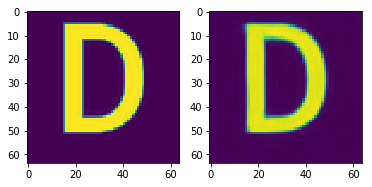

In [21]:
fig, axes = plt.subplots(1,2)
learnAE.model.eval()
rec = learnAE.model(x,y)[0]
axes[0].imshow(x[0].permute(1,2,0).squeeze())
axes[1].imshow(rec[0].permute(1,2,0).squeeze())

In [22]:
def dropout_mask(x:Tensor, sz:Collection[int], p:float):
    "Return a dropout mask of the same type as `x`, size `sz`, with probability `p` to cancel an element."
    return x.new(*sz).bernoulli_(1-p).div_(1-p)

class RNNDropout(nn.Module):
    "Dropout with probability `p` that is consistent on the seq_len dimension."

    def __init__(self, p:float=0.5):
        super().__init__()
        self.p=p

    def forward(self, x:Tensor)->Tensor:
        if not self.training or self.p == 0.: return x
        m = dropout_mask(x.data, (x.size(0), 1, x.size(2)), self.p)
        return x * m

class WeightDropout(nn.Module):
    "A module that warps another layer in which some weights will be replaced by 0 during training."

    def __init__(self, module:nn.Module, weight_p:float, layer_names:Collection[str]=['weight_hh_l0']):
        super().__init__()
        self.module,self.weight_p,self.layer_names = module,weight_p,layer_names
        for layer in self.layer_names:
            #Makes a copy of the weights of the selected layers.
            w = getattr(self.module, layer)
            self.register_parameter(f'{layer}_raw', nn.Parameter(w.data))
            self.module._parameters[layer] = F.dropout(w, p=self.weight_p, training=False)

    def _setweights(self):
        "Apply dropout to the raw weights."
        for layer in self.layer_names:
            raw_w = getattr(self, f'{layer}_raw')
            self.module._parameters[layer] = F.dropout(raw_w, p=self.weight_p, training=self.training)

    def forward(self, *args:ArgStar):
        self._setweights()
        with warnings.catch_warnings():
            #To avoid the warning that comes because the weights aren't flattened.
            warnings.simplefilter("ignore")
            return self.module.forward(*args)

    def reset(self):
        for layer in self.layer_names:
            raw_w = getattr(self, f'{layer}_raw')
            self.module._parameters[layer] = F.dropout(raw_w, p=self.weight_p, training=False)
        if hasattr(self.module, 'reset'): self.module.reset()

class EmbeddingDropout(nn.Module):
    "Apply dropout with probabily `embed_p` to an embedding layer `emb`."

    def __init__(self, emb:nn.Module, embed_p:float):
        super().__init__()
        self.emb,self.embed_p = emb,embed_p
        self.pad_idx = self.emb.padding_idx
        if self.pad_idx is None: self.pad_idx = -1

    def forward(self, words:LongTensor, scale:Optional[float]=None)->Tensor:
        if self.training and self.embed_p != 0:
            size = (self.emb.weight.size(0),1)
            mask = dropout_mask(self.emb.weight.data, size, self.embed_p)
            masked_embed = self.emb.weight * mask
        else: masked_embed = self.emb.weight
        if scale: masked_embed.mul_(scale)
        return F.embedding(words, masked_embed, self.pad_idx, self.emb.max_norm,
                           self.emb.norm_type, self.emb.scale_grad_by_freq, self.emb.sparse)

class AWD_LSTM(nn.Module):
    "AWD-LSTM/QRNN inspired by https://arxiv.org/abs/1708.02182."

    initrange=0.1

    def __init__(self, vocab_sz:int, emb_sz:int, n_hid:int, n_layers:int, pad_token:int=1, hidden_p:float=0.3,
                 input_p:float=0.6, embed_p:float=0.1, weight_p:float=0.5, bidir:bool=False):
        super().__init__()
        self.bs,self.emb_sz,self.n_hid,self.n_layers = 1,emb_sz,n_hid,n_layers
        self.n_dir = 2 if bidir else 1
        self.encoder = nn.Embedding(vocab_sz, emb_sz, padding_idx=pad_token)
        self.encoder_dp = EmbeddingDropout(self.encoder, embed_p)
       
        self.rnns = [nn.LSTM(emb_sz if l == 0 else n_hid, n_hid, 1,
                             batch_first=True, bidirectional=bidir) for l in range(n_layers)]
        self.rnns = [WeightDropout(rnn, weight_p) for rnn in self.rnns]
        self.rnns = nn.ModuleList(self.rnns)
        self.encoder.weight.data.uniform_(-self.initrange, self.initrange)
        self.input_dp = RNNDropout(input_p)
        self.hidden_dps = nn.ModuleList([RNNDropout(hidden_p) for l in range(n_layers)])

    def forward(self, input:Tensor, hs, from_embeddings:bool=False)->Tuple[Tensor,Tensor]:
        if from_embeddings: bs,sl,es = input.size()
        else: bs,sl = input.size()
        if bs!=self.bs:
            self.bs=bs
            self.reset()
        raw_output = self.input_dp(input if from_embeddings else self.encoder_dp(input))
        new_hidden,raw_outputs,outputs = [],[],[]
        for l, (rnn,hid_dp) in enumerate(zip(self.rnns, self.hidden_dps)):
            raw_output, new_h = rnn(raw_output, (hs[0][[l]],hs[1][[l]]))
            new_hidden.append(new_h)
            raw_outputs.append(raw_output)
            if l != self.n_layers - 1: raw_output = hid_dp(raw_output)
            outputs.append(raw_output)
        #self.hidden = to_detach(new_hidden, cpu=False)
        return outputs[-1], (torch.cat([x[0] for x in new_hidden]),torch.cat([x[1] for x in new_hidden]))

    def _one_hidden(self, l:int)->Tensor:
        "Return one hidden state."
        nh = (self.n_hid if l != self.n_layers - 1 else self.emb_sz) // self.n_dir
        return one_param(self).new(self.n_dir, self.bs, nh).zero_()

    def select_hidden(self, idxs):
        self.hidden = [(h[0][:,idxs,:],h[1][:,idxs,:]) for h in self.hidden]
        self.bs = len(idxs)

    def reset(self):
        "Reset the hidden states."
        [r.reset() for r in self.rnns if hasattr(r, 'reset')]
        self.hidden = [(self._one_hidden(l), self._one_hidden(l)) for l in range(self.n_layers)]

In [23]:
ONEOVERSQRT2PI = 1.0 / math.sqrt(2*math.pi)

class MDN(nn.Module):
    """A mixture density network layer
    The input maps to the parameters of a MoG probability distribution, where
    each Gaussian has O dimensions and diagonal covariance.
    Arguments:
        in_features (int): the number of dimensions in the input
        out_features (int): the number of dimensions in the output
        num_gaussians (int): the number of Gaussians per output dimensions
    Input:
        minibatch (BxD): B is the batch size and D is the number of input
            dimensions.
    Output:
        (pi, sigma, mu) (BxG, BxGxO, BxGxO): B is the batch size, G is the
            number of Gaussians, and O is the number of dimensions for each
            Gaussian. Pi is a multinomial distribution of the Gaussians. Sigma
            is the standard deviation of each Gaussian. Mu is the mean of each
            Gaussian.
    """
    def __init__(self, in_features, out_features, num_gaussians):
        super(MDN, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.num_gaussians = num_gaussians
        self.pi = nn.Sequential(nn.Linear(in_features,512),nn.ReLU(inplace=True),nn.Linear(512, out_features*num_gaussians))

        self.sigma = nn.Sequential(nn.Linear(in_features,512),nn.ReLU(inplace=True),nn.Linear(512, out_features*num_gaussians))
        self.mu = nn.Sequential(nn.Linear(in_features,512),nn.ReLU(inplace=True),nn.Linear(512, out_features*num_gaussians))

    def forward(self, minibatch):
        pi = self.pi(minibatch).view(minibatch.shape[0],minibatch.shape[1],self.out_features,self.num_gaussians)
        pi = torch.softmax(pi,dim=3)
        sigma = torch.exp(self.sigma(minibatch))
        sigma = sigma.view(minibatch.shape[0], minibatch.shape[1], self.out_features,self.num_gaussians)
        mu = self.mu(minibatch)
        mu = mu.view(minibatch.shape[0],minibatch.shape[1], self.out_features, self.num_gaussians)
        return pi, sigma, mu

def mdn_loss(pi, sigma, mu, target):
    """Calculates the error, given the MoG parameters and the target
    The loss is the negative log likelihood of the data given the MoG
    parameters.
    """
    ntarget = target.unsqueeze(-1)
    m = torch.distributions.Normal(loc=mu, scale=sigma)
    loss = torch.exp(m.log_prob(ntarget))
    #loss = torch.softmax(m.log_prob(ntarget),dim=2)
    loss = torch.sum(loss * pi, dim=3)
    #print((loss > 1).sum())
    loss = -torch.log(loss+1e-8)
    loss = loss[target != -2.0]
    return loss.mean()

In [53]:
def sample(pi, sigma, mu):
    """Draw samples from a MoG.
    """
    dist = torch.distributions.Categorical(pi)
    s = dist.sample().cuda()
    mu = torch.gather(mu,3,s.unsqueeze(-1)).squeeze(-1)
    sigma = torch.gather(sigma,3,s.unsqueeze(-1)).squeeze(-1)
    dist_n = torch.distributions.Normal(mu,sigma)
    return dist_n.sample().cuda()

In [25]:
pi = torch.softmax(torch.randn(32,50,4,5),dim=3)
sigma = torch.exp(torch.randn(32,50,4,5))
mu = torch.randn(32,50,4,5)
target = torch.randn(32,50,4)

In [26]:
class SVGDecoder(nn.Module):
    def __init__(self,num_tokens,vae_sd):
        super().__init__()
        self.vae = VAE()
        self.vae.load_state_dict(vae_sd)
        requires_grad(self.vae,False)
        self.token_emb = nn.Embedding(num_tokens,4)
        #self.rnn = nn.GRU(4+4+32+16,1024,4,batch_first=True,dropout=0.3)
        #self.rnn = nn.LSTM(4+4+32+16,1024,4,batch_first=True,dropout=0.3)
        self.rnn = AWD_LSTM(62,4+4+32+16,1024,4,0,input_p=0.0)
        self.z_to_hidden = nn.Linear(32+16,1024)
        self.token = nn.Linear(1024,num_tokens)
#         #self.pen = nn.Linear(1024,4)
        self.pen = MDN(1024,4,64)
        self.mask = torch.tensor([[0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0]]).cuda()
        
    def get_preds(self, png, char_class, use_mean=False):
        #z (bsx48)
        z = self.vae.get_z(png,char_class).detach()
        hs = self.z_to_hidden(z).unsqueeze(0).expand(4,-1,-1).contiguous()
        cs = torch.zeros_like(hs)
        tools = [torch.zeros(z.shape[0],1,dtype=torch.long).fill_(8).cuda()]
        pens = [torch.zeros(z.shape[0],1,4).fill_(-2.0).cuda()]
        i = 0
        while i < 200:
            r_in = torch.cat([self.token_emb(tools[-1]),pens[-1],z.unsqueeze(1)],dim=2)
            output, (hs,cs) = self.rnn(r_in,(hs,cs),from_embeddings=True)
            tool = self.token(output)
            u = tool[tools[-1].squeeze() == 6]
            tool[tools[-1].squeeze() == 6] = torch.where(self.mask.unsqueeze(0).expand_as(u)==1.0,u,torch.zeros_like(u).fill_(-1e9))
            if use_mean:
                pi,_,pen = self.pen(output)
                pi = torch.argmax(pi,dim=3,keepdim=True)
                pen = torch.gather(pen,3,pi).squeeze(-1)
            else:            
                pen = self.pen(output)
                pen = sample(*pen)
            tools.append(torch.argmax(tool,dim=2))
            pens.append(pen)
            i += 1
            
        return torch.cat(tools,dim=1), torch.cat(pens,dim=1)

    def get_preds_mean(self, png, char_class):
        #z (bsx48)
        z = self.vae.get_z(png,char_class,False).detach()
        hs = self.z_to_hidden(z).unsqueeze(0).expand(4,-1,-1).contiguous()
        cs = torch.zeros_like(hs)
        tools = [torch.zeros(z.shape[0],1,dtype=torch.long).fill_(8).cuda()]
        pens = [torch.zeros(z.shape[0],1,4).fill_(-2.0).cuda()]
        i = 0
        while i < 200:
            r_in = torch.cat([self.token_emb(tools[-1]),pens[-1],z.unsqueeze(1)],dim=2)
            output, (hs,cs) = self.rnn(r_in,(hs,cs),from_embeddings=True)
            tool = self.token(output)
            u = tool[tools[-1].squeeze() == 6]
            tool[tools[-1].squeeze() == 6] = torch.where(self.mask.unsqueeze(0).expand_as(u)==1.0,u,torch.zeros_like(u).fill_(-1e9))
            pi,_,pen = self.pen(output)
            pi = torch.argmax(pi,dim=3,keepdim=True)
            pen = torch.gather(pen,3,pi).squeeze(-1)
            tools.append(torch.argmax(tool,dim=2))
            pens.append(pen)
            i += 1
        return torch.cat(tools,dim=1), torch.cat(pens,dim=1)
    
    def get_preds_from_output(self,tokens,pi,sigma,mu):
        tokens = torch.argmax(tokens,dim=2)
        pi = torch.argmax(pi,dim=3,keepdim=True)
        mu = torch.gather(mu,3,pi).squeeze(-1)
        return tokens,mu
    
    def forward(self, png, char_class,tokens, pen, return_preds=False):
        z = self.vae.get_z(png,char_class).detach()
        tokens = self.token_emb(tokens)
        hs = self.z_to_hidden(z).unsqueeze(0).expand(4,-1,-1).contiguous()
        r_in = torch.cat([tokens,pen,z.unsqueeze(1).expand(-1,tokens.shape[1],-1)],dim=2)
        #self.rnn.flatten_parameters()
        output, (hs,cs) = self.rnn(r_in,(hs,torch.zeros_like(hs)),from_embeddings=True)
        
        tokens = self.token(output)
        #pens = self.pen(output)
        #return tokens, pens
        pi,sigma,mu = self.pen(output)
        
        if return_preds:
            return tokens, (pi[:,:-1],sigma[:,:-1], mu[:,:-1]), self.get_preds_from_output(tokens,pi,sigma,mu)
        return tokens, (pi[:,:-1],sigma[:,:-1], mu[:,:-1]), output

In [27]:
class SVGDecoderLoss(nn.Module):
    def forward(self,preds,target_tokens,target_pen):
        tokens, pen = preds
        mask = target_tokens != 0
        loss_token = F.cross_entropy(tokens.transpose(1,2)[:,:,:-1],target_tokens,reduction="none")[mask].mean()
        #loss_token = 10*F.cross_entropy(tokens.transpose(1,2)[:,:,:-1],target_tokens)
        loss_pen = mdn_loss(*pen,target_pen)
        self.l_t = loss_token.item()
        self.l_p = loss_pen.item()
#         with torch.no_grad():
#             self.l_mse = F.mse_loss(mpreds[1][:,:-1],target_pen,reduction="none")[target_pen != -2.0].mean().item()
        self.l_mse = 0.0
        return loss_token + loss_pen

class SVGDecoderTrainer(LearnerCallback):
    _order=-20
    def on_train_begin(self,**kwargs):
        self.smoothCE, self.smoothMDN, self.smoothMSE = SmoothenValue(0.98), SmoothenValue(0.98), SmoothenValue(0.98)
        self.learn.recorder.add_metric_names(["ce","mdn", "mse"])
        
    def on_batch_begin(self, last_input, last_target, **kwargs):
        return {"last_input": (last_input,last_target[2],last_target[0],last_target[1]), "last_target": (last_target[0][:,1:],last_target[1][:,1:])}
    
    def on_loss_begin(self, last_output, **kwargs):
        self.out = last_output[2]
        return {"last_output": last_output[:2]}
    
    def on_backward_begin(self,last_loss, **kwargs):
        last_loss += 2.0 * self.out.float().pow(2).mean()
        return {"last_loss": last_loss}
       
    def on_batch_end(self,**kwargs):
        self.smoothCE.add_value(self.learn.loss_func.l_t)
        self.smoothMDN.add_value(self.learn.loss_func.l_p)
        self.smoothMSE.add_value(self.learn.loss_func.l_mse)
        
    def on_epoch_end(self, epoch, last_metrics, **kwargs):
        self.learn.save("svg_awd_full")
        return add_metrics(last_metrics,[self.smoothCE.smooth,self.smoothMDN.smooth,self.smoothMSE.smooth])

In [62]:
learnSVG = Learner(data,SVGDecoder(len(data.vocab),learnAE.model.state_dict()),loss_func=SVGDecoderLoss(),callback_fns=[SVGDecoderTrainer])

In [ ]:
learnSVG.fit_one_cycle(120,3e-4)

epoch,train_loss,valid_loss,ce,mdn,mse,time
0,-0.523415,#na#,0.861071,-1.384485,0.000000,05:35
1,-0.586743,#na#,0.838944,-1.425687,0.000000,05:35


In [180]:
learnSVG.save("svg_awd")

In [63]:
learnSVG.load("svg_awd_full");

/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type RNNDropout. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type SVGDecoderLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type SVGDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type VAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/op

In [30]:
def get_pred_path(x,labels,mean=False,i=0):
    learnSVG.model.eval()
    with torch.no_grad():
        if mean:
            tools, pens = learnSVG.model.get_preds_mean(x,labels)
        else:
            tools, pens = learnSVG.model.get_preds(x,labels)
    out = []
    for t,p in zip(tools[i,1:-1],pens[i,1:-1]):
        t = data.vocab[t]
        out.append(t)
        out.append(" ".join([str(int(np.rint(500*n.item()))) for n in p[:len(tool_dict[t])]]))
    return " ".join(out)

In [31]:
def path_from_tensors(tools,pens,i=0):
    p = ""
    for t,pen in zip(tools[i,1:],pens[i,1:]):
        tool = data.vocab[t]
        if tool == "END": break
        pen = [str(int(np.rint(x.item()))) for x in pen*500]
        p = p + tool + " " + " ".join(pen[:len(tool_dict[tool])]) + " "
    return p

In [108]:
x,y = next(iter(data.train_dl))
labels = y[2]

In [109]:
po = path_from_tensors(y[0],y[1])
po

'M 186 140 l 10 0 l -5 41 q 41 -46 90 -46 q 38 0 57 24 t 20 70 q 0 39 -13 79 t -41 68 t -73 28 q -36 0 -69 -14 l -15 106 l -11 2 z  M 298 368 q 26 -26 38 -64 t 11 -73 q 0 -42 -17 -64 t -49 -22 q -28 0 -49 13 t -43 38 l -26 184 q 32 14 67 14 q 42 0 68 -26 z  '

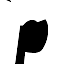

In [110]:
p = get_pred_path(x[[0]],labels[[0]])
p = p[:p.find("END")-1]
#p
render_path_wand(p,500,500)

In [111]:
p_mean = get_pred_path(x[[0]],labels[[0]],mean=True)
#p_mean = p_mean[:p_mean.find("z")+1]
p_mean = p_mean[:p_mean.find("END")-1]
#p_mean = p_mean[:len(po)]
p_mean

'M 189 151 l 37 0 l -1 33 q 29 -41 38 -40 t 38 0 q 35 0 56 86 t 20 72 q -61 23 -14 87 t -43 64 t -76 23 q -34 0 -56 -10 l -16 105 l -43 4 z  M 23 0 z  M 30 0 z  M 28 0 z  M -7 0 z  M -43 0 z  M -1 0 z  M 0 0 z  M -2 4 z '

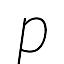

In [112]:
render_path_wand(path_from_tensors(y[0],y[1]),500,500)

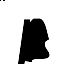

In [113]:
render_path_wand(p_mean,500,500)

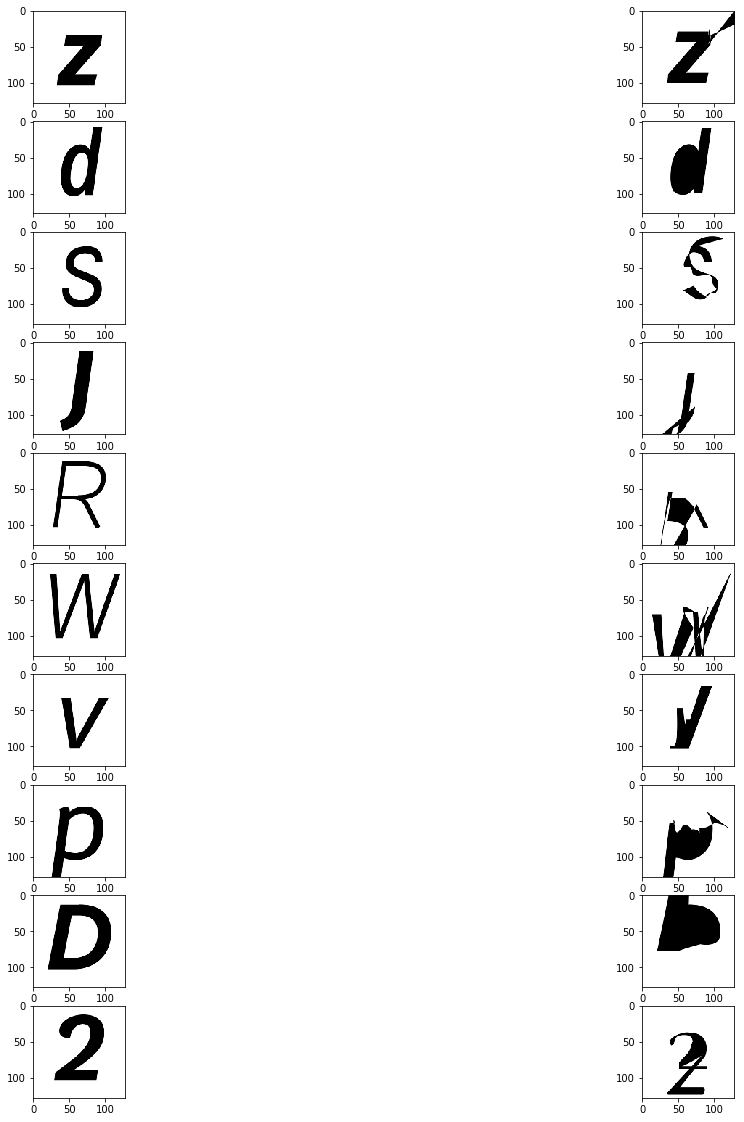

In [203]:
fig,axes = plt.subplots(10,2,figsize=(20,20))
for i in range(10):
    rp = path_from_tensors(y[0],y[1],i)
    rp = render_path_wand(rp,500,500)
    axes[i][0].imshow(rp)
    p = get_pred_path(x[[i]],labels[[i]],mean=True)
    ie = p.find("END")
    if ie is not None:
        p = p[:ie-1]
    else:
        p = p[:p.find("z")+1]

    #p = p[:len(rp)]
    img = render_path_wand(p,500,500)
    axes[i][1].imshow(img)

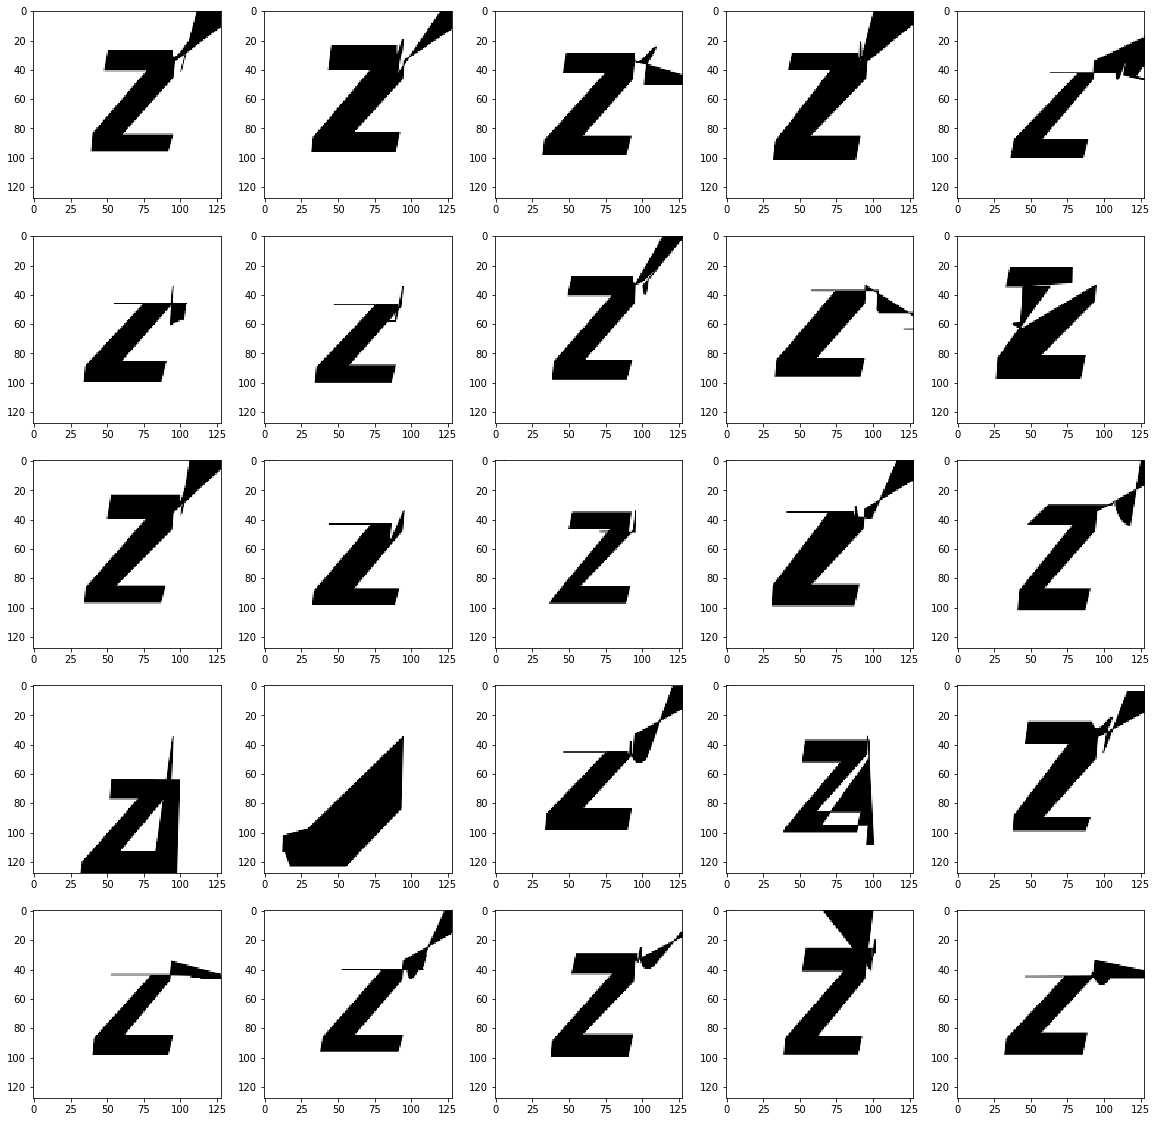

In [204]:
fig,axes = plt.subplots(5,5,figsize=(20,20))
i = 0
for ax in axes.flatten():
    p = get_pred_path(x[[i]],labels[[i]],mean=False)
    p = p[:p.find("END")-1]
    img = render_path_wand(p,500,500)
    ax.imshow(img)

In [122]:
class Agent(nn.Module):
    def __init__(self,num_tools,encoder_sd=None,tool_emb_sd=None):
        super().__init__()
        self.cnn = nn.Sequential(
            conv2d(1,32,5,1,2),
            nn.InstanceNorm2d(32,affine=True),
            nn.ReLU(),
            conv2d(32,32,5,2,2),
            nn.InstanceNorm2d(32,affine=True),
            nn.ReLU(),
            conv2d(32,64,5,1,2),
            nn.InstanceNorm2d(64,affine=True),
            nn.ReLU(),
            conv2d(64,64,5,2,2),
            nn.InstanceNorm2d(64,affine=True),
            nn.ReLU(),
            conv2d(64,64,3,2,1),
            nn.InstanceNorm2d(64,affine=True),
            nn.ReLU(),
            conv2d(64,64,3,2,1),
            nn.InstanceNorm2d(64,affine=True),
            nn.ReLU())
        
        if encoder_sd is not None: self.cnn.load_state_dict(encoder_sd)
        
        self.flatten = nn.Sequential(AdaptiveConcatPool2d(1),Flatten())
        self.tool_emb = nn.Embedding(num_tools,4)
        if tool_emb_sd is not None: self.tool_emb.load_state_dict(tool_emb_sd)
        requires_grad(self.tool_emb,False)
        self.sv_to_hs = nn.Linear(128,128)
        self.path_encoder = nn.LSTM(4+4,128,2,batch_first=True)
        self.tool_sel = nn.Linear(128,1)
        self.num_tools = num_tools
        self.adjust_mean = nn.Linear(128,num_tools*4)
        self.adjust_std = nn.Linear(128,num_tools*4)
        self.template = torch.arange(0,201).unsqueeze(0).expand(64,-1).cuda()
        
    def forward(self, state, tools, pens, explore=True):
        sv = self.flatten(self.cnn(state))
        u = torch.cat([self.tool_emb(tools),pens],dim=2)
        hs = self.sv_to_hs(sv).unsqueeze(0).expand(2,-1,-1).contiguous()
        output,_ = self.path_encoder(u,(hs,torch.zeros_like(hs)))
        
        actions = torch.softmax(self.tool_sel(output).squeeze(-1),dim=1)
        mean = 0.1*torch.tanh(self.adjust_mean(output).view(tools.shape[0],-1,self.num_tools,4))
        std = 0.1*torch.sigmoid(self.adjust_std(output).view(tools.shape[0],-1,self.num_tools,4))
        mask = (tools != 0) & (tools != 8) & (tools != 9) & (tools != 6)
        first_end = torch.argmax(tools==9,dim=1,keepdim=True)

        mask = mask & (self.template < first_end)
        actions = torch.where(mask,actions,torch.zeros_like(actions))
        
        #action_probs,action = torch.max(actions,dim=1)
        dist_action = torch.distributions.Categorical(actions)
        action = dist_action.sample()
        action_log_probs = dist_action.log_prob(action)
        t = tools[torch.arange(tools.shape[0]),action]
        mean = mean[torch.arange(mean.shape[0]),action,t]
        std = std[torch.arange(std.shape[0]),action,t]
        adjust = torch.zeros_like(pens)
        if explore:
            
            dist = torch.distributions.Normal(mean,std)
            d = dist.sample()
            adjust[torch.arange(tools.shape[0]),action] = d
            return (pens + adjust), action_log_probs, dist.log_prob(d), action
        else:
            d = mean
            adjust[torch.arange(tools.shape[0]),action] = d
            return (pens + adjust)

In [125]:
class AgentInitTrainer(LearnerCallback):
    def on_batch_begin(self, last_input, last_target, **kwargs):
        state = [path_from_tensors(last_target[0],last_target[1],i) for i in range(last_target[0].shape[0])]
        state = render_paths(state)
        mask = (last_target[0][:,1:] != 0).unsqueeze(-1).expand(-1,-1,4) & (last_target[1][:,1:] != -2.0)
        return {"last_input": (state, last_target[0][:,1:], last_target[1][:,1:]), "last_target": (last_target[1][:,1:],mask)}
    
def agent_init_loss(preds, target, mask):
    npens,_,_= preds
    return F.mse_loss(npens,target, reduction="none")[mask].mean()

In [81]:
learnAgentInit = Learner(data,Agent(len(data.vocab),learnAE.model.encoder.state_dict(),learnSVG.model.token_emb.state_dict()),loss_func=agent_init_loss,callback_fns=[AgentInitTrainer])

In [58]:
def tensors_to_path_string(tools,pens):
    paths = []
    for i in range(tools.shape[0]):
        out = []
        for t,p in zip(tools[i],pens[i]):
            t = data.vocab[t]
            out.append(t)
            out.append(" ".join([str(int(np.rint(500*n.item()))) for n in p[:len(tool_dict[t])]]))
        path = " ".join(out)
        path = path[:path.find("END")-1]
        paths.append(path)
    return paths

In [139]:
def get_pred_paths(x,labels,mean=True):
    learnSVG.model.eval()
    with torch.no_grad():
        if mean:
            tools, pens = learnSVG.model.get_preds_mean(x,labels)
        else:
            tools, pens = learnSVG.model.get_preds(x,labels)
        
    paths = tensors_to_path_string(tools[:,1:-1],pens[:,1:-1])
    return paths,tools,pens

In [36]:
def render_paths(paths):
    return torch.stack([wand_to_tensor(render_path_wand(p,500,500)) for p in paths]).unsqueeze(1).cuda()

In [140]:
#x,y = next(iter(data.train_dl))
target_paths = [path_from_tensors(y[0],y[1],i) for i in range(x.shape[0])]
targets = render_paths(target_paths)[[0]].expand(64,-1,-1,-1)

paths, tools, pens = get_pred_paths(x,y[2])
start_state = render_paths(paths)[[0]].expand(64,-1,-1,-1)
start_state_tools = tools[[0]].expand(64,-1)
start_state_pens = pens[[0]].expand(64,-1,-1)

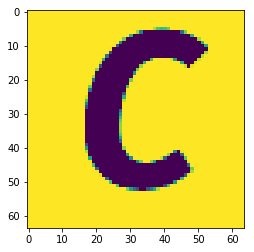

In [141]:
plt.imshow(targets[0,0])

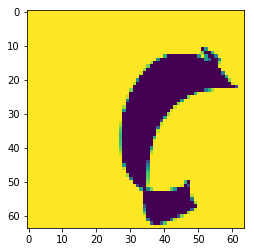

In [142]:
plt.imshow(start_state[0,0])

Epoch 0: 0.056525424122810364 -0.6100371479988098


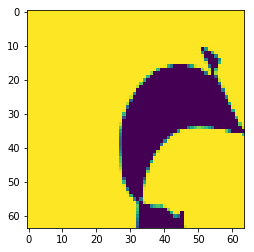

Epoch 1: 0.1804703325033188 0.9626850485801697


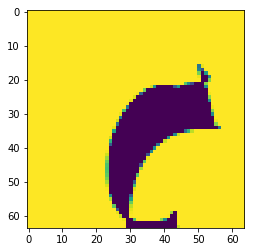

Epoch 2: 0.15729066729545593 0.6568151712417603


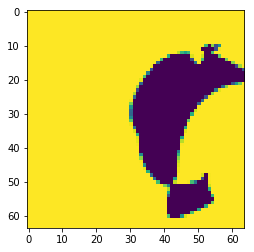

Epoch 3: 0.21906180679798126 1.2876763343811035


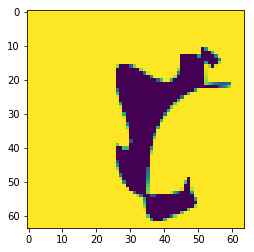

Epoch 4: 0.2435780167579651 -0.696641206741333


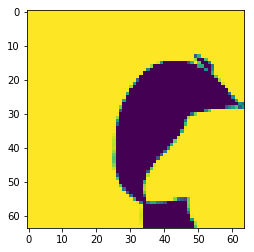

Epoch 5: 0.2714958190917969 2.6189637184143066


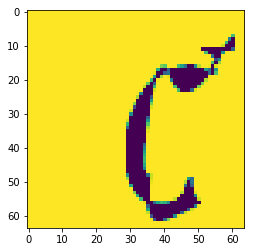

Epoch 6: 0.20458614826202393 1.3461644649505615


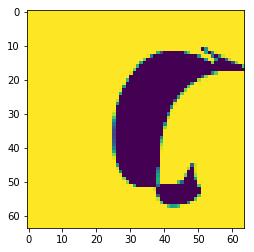

Epoch 7: 0.3286011815071106 6.281794548034668


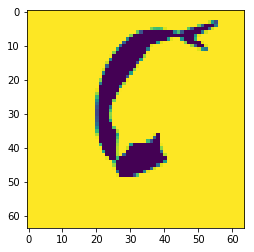

Epoch 8: 0.1952843964099884 0.18929511308670044


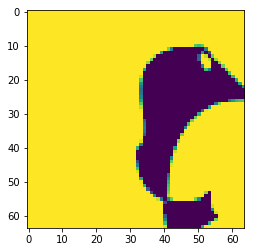

Epoch 9: 0.2680826187133789 0.2510419487953186


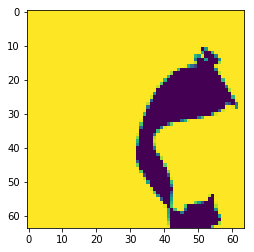

In [145]:
baseline = F.mse_loss(start_state,targets,reduction="none").view(start_state.shape[0],-1).mean(dim=1)
agent = Agent(len(data.vocab),learnAE.model.encoder.state_dict(),learnSVG.model.token_emb.state_dict()).cuda()
opt_agent = torch.optim.SGD(agent.parameters(),lr=1e-3)

for epoch in range(10):
    state, state_tools, state_pens = start_state, start_state_tools, start_state_pens
    action_log_probs, pen_log_probs, rewards, actions = [], [], [], []
    for t in range(4):
        npens, action_probs, pen_probs, action = agent(state,state_tools,state_pens)
        #print(state_pens-npens)
        state_pens = npens
        #print(tensors_to_path_string(state_tools[:,1:],state_pens[:,1:]))
        state = render_paths(tensors_to_path_string(state_tools[:,1:],state_pens[:,1:]))
        reward = baseline - F.mse_loss(state,targets,reduction="none").view(state.shape[0],-1).mean(dim=1)
        action_log_probs.append(action_probs)
        pen_log_probs.append(pen_probs)
        rewards.append(reward*10)
        actions.append(action.detach())
    
    action_log_probs = torch.stack(action_log_probs,dim=1)
    pen_log_probs = torch.stack(pen_log_probs,dim=1)
    rewards = torch.stack(rewards,dim=1)
    actions = torch.stack(actions,dim=1)
    #print(rewards.shape)
    ##print(rewards)
    #rewards = (rewards - torch.mean(rewards)) / torch.std(rewards)
    #print(action_log_probs.shape,pen_log_probs.shape,rewards.shape)
    loss = -(rewards * action_log_probs).mean() + -(rewards.unsqueeze(-1) * pen_log_probs).mean()
    opt_agent.zero_grad()
    loss.backward()
    print(f"Epoch {epoch}: {loss.item()} {rewards[0].sum().item()}")
    opt_agent.step()
    
        
    plt.imshow(state[0,0])
    plt.show()

In [165]:
class RectifyTransformer(nn.Module):
    "Transformer model: https://arxiv.org/abs/1706.03762."
    def __init__(self, vocab_sz:int, ctx_len:int, n_layers:int, n_heads:int, d_model:int, d_head:int, d_inner:int,
                 resid_p:float=0., attn_p:float=0., ff_p:float=0., embed_p:float=0., bias:bool=True, scale:bool=True,
                 act:Activation=Activation.ReLU, double_drop:bool=True, attn_cls:Callable=MultiHeadAttention,
                 learned_pos_enc:bool=True, mask:bool=True, tool_emb_sd=None):
        super().__init__()
        self.mask = mask
        self.tool_emb = nn.Embedding(len(data.vocab),4)
        if tool_emb_sd is not None:
            self.tool_emb.load_state_dict(tool_emb_sd)
        #self.encoder = nn.Embedding(vocab_sz, d_model)
        self.pos_enc = nn.Embedding(ctx_len, d_model) if learned_pos_enc else PositionalEncoding(d_model)
        self.drop_emb = nn.Dropout(embed_p)
        self.layers = nn.ModuleList([DecoderLayer(n_heads, d_model, d_head, d_inner, resid_p=resid_p, attn_p=attn_p,
                      ff_p=ff_p, bias=bias, scale=scale, act=act, double_drop=double_drop,
                      attn_cls=attn_cls) for k in range(n_layers)])
        self.out = nn.Linear(9,4)

    def reset(self): pass

    def forward(self, tools, pens):
        bs, x_len, pen_size = pens.size()
        pos = torch.arange(0, x_len, device=pens.device, dtype=pens.dtype)
        tools = self.tool_emb(tools)
        inp = torch.cat([pos.view(1,-1,1).expand(bs,-1,-1),tools,pens],dim=2)
        mask = torch.triu(pens.new_ones(x_len, x_len), diagonal=1).byte()[None,None] if self.mask else None
        #[None,:,:None] for einsum implementation of attention
        for layer in self.layers: inp = layer(inp, mask=mask)
        return pens + torch.tanh(self.out(inp))
        #return ([inp],[inp]) #For the LinearDecoder
        
class RectifyTrainer(LearnerCallback):
    def on_batch_begin(self, last_input, last_target, **kwargs):
        learnSVG.model.eval()
        with torch.no_grad():
            tools, pens = learnSVG.model.get_preds(last_input,last_target[2])
            
        return {"last_input": (tools,pens), "last_target": last_target[1]}

def rectify_loss(preds,target):
    target = target[:,1:200]
    mask = (target != -2.0)
    loss = F.mse_loss(preds[:,1:target.shape[1]+1],target,reduction="none")[mask].mean()
    return loss

In [166]:
t = RectifyTransformer(62,5,6,4,1+4+4,32,64,learned_pos_enc=False,tool_emb_sd=learnSVG.model.token_emb.state_dict())
learnRectify = Learner(data,t,loss_func=rectify_loss,callback_fns=[RectifyTrainer])

In [167]:
learnRectify.fit(20,3e-3)

epoch,train_loss,valid_loss,time
0,0.033348,#na#,00:25
1,0.025710,#na#,00:25
2,0.023460,#na#,00:25
3,0.022415,#na#,00:25
4,0.021936,#na#,00:25
5,0.021703,#na#,00:25
6,0.021709,#na#,00:25


KeyboardInterrupt: 

In [160]:
t(torch.randint(0,len(data.vocab),(32,50)),torch.randn(32,50,4)).shape

torch.Size([32, 50, 4])

In [54]:
class ConvBlock(nn.Module):
    def __init__(self,in_size,out_size,stride=1,final_relu=True):
        super().__init__()
        self.out_size = out_size
        self.final_relu = final_relu
        self.conv = nn.Sequential(
                       conv2d(in_size,out_size,ks=(3,1),stride=(stride,1),padding=(1,0),bias=False),
                       nn.ReLU(inplace=True),
                       conv2d(out_size,out_size,ks=(3,1),stride=1,padding=(1,0),bias=False))
        self.shortcut = conv2d(in_size,out_size,ks=(3,1),stride=(stride,1),padding=(1,0),bias=False)
        
    def forward(self, x):
        u = self.conv(x)
        
        if x.shape[1] != self.out_size:
            x = self.shortcut(x)
            
        x = x + u
        if self.final_relu:
            x = F.relu(x)
        return x


class RectifyNet(nn.Module):
    def __init__(self):
        super().__init__()
        blocks = [1,8,16,8,1]
        self.conv = nn.Sequential(*[ConvBlock(i,o,1,final_relu=(o!=1)) for i,o in zip(blocks,blocks[1:])])
        
    def forward(self, pens):
        #pens bs x seq x 4
        #tokens bs x seq
        
        u = pens.unsqueeze(1)
        u = self.conv(u)
            
        return u.squeeze(1)

    
class UpBlock(nn.Module):
    def __init__(self,up_in,c_in):
        super().__init__()
        self.conv_up = conv2d_trans(up_in,c_in,ks=(3,1),stride=(2,1),padding=(1,0))
        self.conv = nn.Sequential(conv_layer(c_in*2,c_in),conv_layer(c_in,c_in,use_activ=False))
        
    def forward(self, x, c):
        u = self.conv_up(x)
        u = torch.cat([u,c],dim=1)
        return self.conv(u)
        
    
class RectifyUNet(nn.Module):
    def __init__(self):
        super().__init__()
        encoder_blocks = [1,8,16,32]
        self.encoder = nn.ModuleList([ConvBlock(i,o,2) for i,o in zip(encoder_blocks,encoder_blocks[1:])])
        
        self.middle_conv = nn.Sequential(conv_layer(32,64),conv_layer(64,32))
        
        decoder_blocks = [32,16,8,1]
        self.decoder = nn.ModuleList([UpBlock(i,o) for i,o in zip(decoder_blocks,decoder_blocks[1:])])
        
        
    def forward(self, pens): 
        u = pens.unsqueeze(1)
        outputs = [u]
        for l in self.encoder:
            u = l(u)
            outputs.append(u)
            
        u = self.middle_conv(u)
        
        for o,l in zip(reversed(outputs[:-1]),self.decoder):
            u = l(u,o)
            
        return pens + u.squeeze(1)

class RectifyRNN(nn.Module):
    def __init__(self,tool_size,tool_emb_sd=None):
        super().__init__()
        self.tool_emb = nn.Embedding(tool_size,4)
        if tool_emb_sd is not None: self.tool_emb.load_state_dict(tool_emb_sd)
        self.rnn = nn.LSTM(8,128,3,batch_first=True)
        #self.out = nn.Sequential(nn.Linear(128,32),nn.ReLU(),nn.Linear(32,4))
        self.out = MDN(128,4,32)
                
    def forward(self, tools, pens):
        u = torch.cat([self.tool_emb(tools),pens],dim=2)
        output,_ = self.rnn(u)
        pen = self.out(output)
        return pen
        
class RectifyTrainer(LearnerCallback):
    _order = -20
    
    def on_train_begin(self, **kwargs):
        self.smoothMSE = SmoothenValue(0.98)
        self.learn.recorder.add_metric_names(["mse"])
    
    def on_batch_begin(self, last_input, last_target, **kwargs):
        learnSVG.model.eval()
        with torch.no_grad():
            tools, pens = learnSVG.model.get_preds(last_input,last_target[2])
            
        return {"last_input": (tools,pens), "last_target": last_target[1]}
    
    def on_batch_end(self, last_output, last_target, **kwargs):
        s = sample(*last_output)
        target = last_target[:,1:200]
        mask = (target != -2.0)
        mse = F.mse_loss(s[:,1:target.shape[1]+1],target,reduction="none")[mask].mean()
        self.smoothMSE.add_value(mse.item())
        
    def on_epoch_end(self, last_metrics, **kwargs):
        return add_metrics(last_metrics,[self.smoothMSE.smooth])

# def rectify_loss(preds,target):
#     target = target[:,1:200]
#     mask = (target != -2.0)
#     loss = F.mse_loss(preds[:,1:target.shape[1]+1],target,reduction="none")[mask].mean()
#     return loss

def rectify_loss(preds,target):
    target = target[:,1:200]
    preds = [p[:,1:target.shape[1]+1] for p in preds]
    return mdn_loss(*preds,target)

In [55]:
learnRectify = Learner(data,RectifyRNN(len(data.vocab),learnSVG.model.token_emb.state_dict()),loss_func=rectify_loss,callback_fns=[RectifyTrainer])

In [56]:
learnRectify.fit(50,3e-3)

epoch,train_loss,valid_loss,mse,time
0,-0.577804,#na#,0.153025,00:24
1,-0.767839,#na#,0.083858,00:24
2,-0.857364,#na#,0.060303,00:25
3,-0.889007,#na#,0.050394,00:25
4,-0.911556,#na#,0.045317,00:25
5,-0.934760,#na#,0.042454,00:25
6,-0.947730,#na#,0.041969,00:25
7,-0.977621,#na#,0.041316,00:25
8,-0.972721,#na#,0.042033,00:25
9,-0.963477,#na#,0.041098,00:25


KeyboardInterrupt: 

In [159]:
def get_pred_path_rect(x,labels,mean=False):
    learnSVG.model.eval()
    with torch.no_grad():
        if mean:
            tools, pens = learnSVG.model.get_preds_mean(x,labels)
        else:
            tools, pens = learnSVG.model.get_preds(x,labels)
    pens = learnRectify.model(pens)
    out = []
    for t,p in zip(tools[0,1:-1],pens[0,1:-1]):
        t = data.vocab[t]
        out.append(t)
        out.append(" ".join([str(int(np.rint(500*n.item()))) for n in p[:len(tool_dict[t])]]))
    return " ".join(out)

In [160]:
def get_pred_path_both(x,labels,mean=False,i=0):
    learnSVG.model.eval()
    with torch.no_grad():
        if mean:
            tools, pens = learnSVG.model.get_preds_mean(x,labels)
        else:
            tools, pens = learnSVG.model.get_preds(x,labels)

    out = []
    for t,p in zip(tools[i,1:-1],pens[i,1:-1]):
        t = data.vocab[t]
        out.append(t)
        out.append(" ".join([str(int(np.rint(500*n.item()))) for n in p[:len(tool_dict[t])]]))
    norect = " ".join(out)
    
    pens2 = learnRectify.model(pens)
    out = []
    for t,p in zip(tools[i,1:-1],pens2[i,1:-1]):
        t = data.vocab[t]
        out.append(t)
        out.append(" ".join([str(int(np.rint(500*n.item()))) for n in p[:len(tool_dict[t])]]))
    rect = " ".join(out)
    return norect, rect

In [161]:
x,y = next(iter(data.train_dl))
labels = y[2]

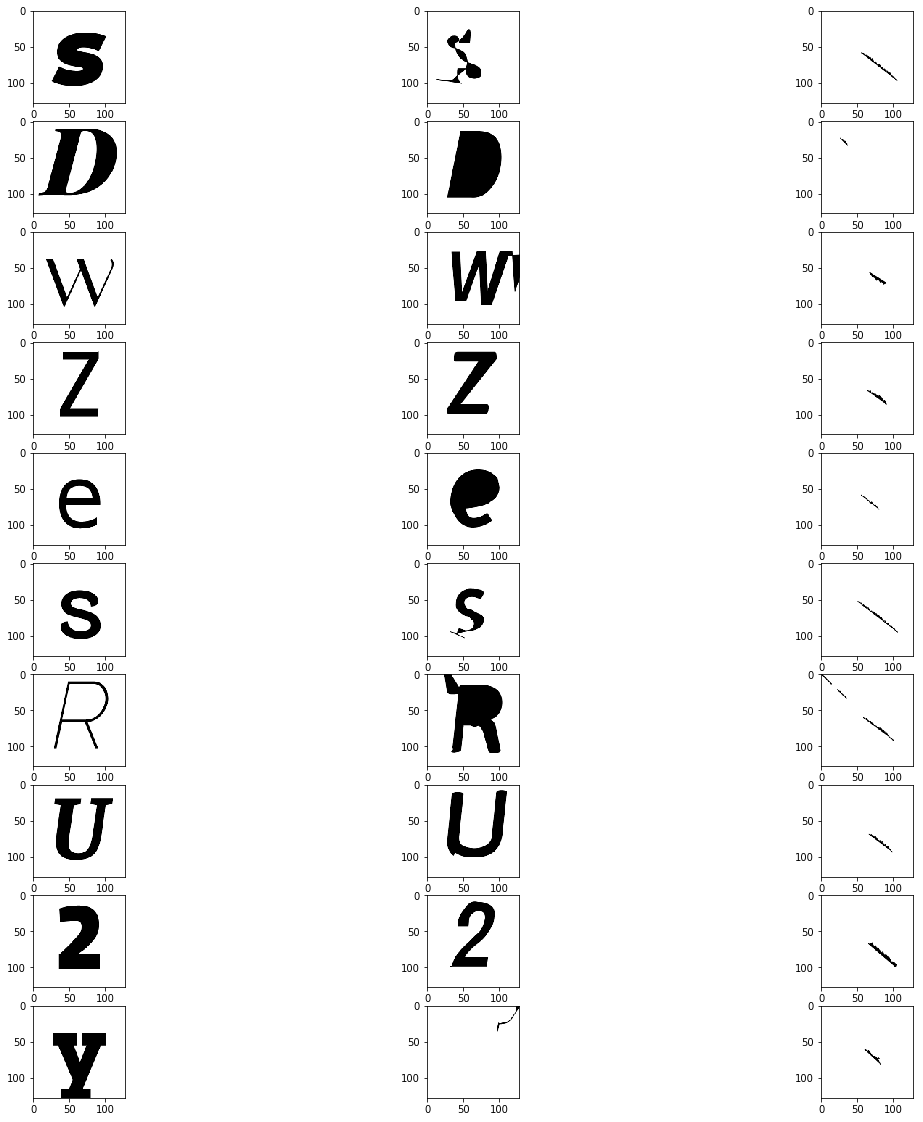

In [162]:
fig, axes = plt.subplots(10,3,figsize=(20,20))
for i in range(10):
    orig = render_path_wand(path_from_tensors(y[0],y[1],i),500,500)
    norect,rect = get_pred_path_both(x,labels,mean=True,i=i)
    #norect = norect[:len(orig)]
    #rect = rect[:len(orig)]
    norect = norect[:norect.find("END")-1]
    rect = rect[:rect.find("END")-1]
    norect = render_path_wand(norect,500,500)
    rect = render_path_wand(rect,500,500)
    axes[i,0].imshow(orig)
    axes[i,1].imshow(norect)
    axes[i,2].imshow(rect)

In [36]:
p_mean = get_pred_path_rect(x[[0]],labels[[0]],mean=True)
#p_mean = p_mean[:p_mean.find("z")+1]
p_mean = p_mean[:p_mean.find("END")-1]
#p_mean = p_mean[:len(po)]
p_mean

'M 291 330 q -8 45 -34 74 t -49 48 t -67 29 l -17 -53 q 23 -9 35 -20 t 19 -27 t 9 -36 l 41 -298 l 89 0 z  PAD  z  PAD '

In [37]:
render_path_wand(path_from_tensors(y[0],y[1]),500,500)

NameError: name 'path_from_tensors' is not defined

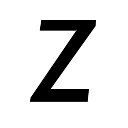

In [314]:
render_path_wand(p_mean,500,500)

In [49]:
class SVGDiscriminator(nn.Module):
    def __init__(self,num_tokens):
        super().__init__()
        self.token_emb = nn.Embedding(num_tokens,4)
        #self.rnn = nn.GRU(4+4,1024,4,batch_first=True,dropout=0.3)
        self.rnn = nn.LSTM(4+4,1024,4,batch_first=True,dropout=0.3)
        self.out = nn.Sequential(nn.Linear(1024,128),nn.ReLU(),nn.Linear(128,1))
               
        
    def forward(self, tokens, pen):
        tokens = self.token_emb(tokens)
        r_in = torch.cat([tokens,pen],dim=2)
        #self.rnn.flatten_parameters()
        output, (hs,cs) = self.rnn(r_in)
        
        return self.out(output[:,-1])
    
class NGAN(nn.Module):
    def __init__(self,generator,discriminator,num_classes=None):
        super().__init__()
        self.gen = generator
        self.disc = discriminator
        
    def forward(self, png, char_class,tokens, pen, return_preds=False):
        return self.gen(png, char_class,tokens, pen, return_preds)
    
def noop_loss(preds,target): return torch.tensor(0.0)

In [55]:
def clean_preds(p_tokens,p_pen,r_tokens,r_pen):
    p_tokens[:,:-1][r_tokens == 0] = 0
    p_pen[:,:-1][r_pen == -2.0] = -2.0
    return p_tokens,p_pen

class SVGGanTrainer(LearnerCallback):
    _order=-20
    
    def on_train_begin(self, **kwargs):
        self.learn.opt = self.learn.opt.new([nn.Sequential(*flatten_model(self.learn.model.disc))])
        self.opt_disc = self.learn.opt
        self.opt_gen = self.learn.opt.new([nn.Sequential(*flatten_model(self.learn.model.gen))])
        self.opt_gen.lr = 3e-4
        self.smoothenerG,self.smoothenerD,self.smoothenerMix,self.smoothenerReal = SmoothenValue(0.98),SmoothenValue(0.98),SmoothenValue(0.98),SmoothenValue(0.98)
        self.sublosses = ["g_d","gen_rec"]
        self.smoothDict = {sl: SmoothenValue(0.98) for sl in self.sublosses}
        self.recorder.add_metric_names(['gen_loss', 'disc_loss'] + self.sublosses)
        self.m_labels = torch.eye(10).cuda()
        self.it = 0
        self.gen_loss = SVGDecoderLoss()
        #self.gen_copy = UpAE().cuda()
        #self.gen_copy.load_state_dict(self.learn.model.gen.state_dict())
        
    def on_batch_begin(self, last_input, last_target, **kwargs):
        requires_grad(self.learn.model.gen,False)
        requires_grad(self.learn.model.disc,True)
        self.learn.model.train()
        self.last_input = last_input
        self.last_target = last_target
        return {"last_input": (last_input, last_target[2], last_target[0], last_target[1],True),"last_target": 0}
    
    def on_backward_begin(self, train, last_input, last_output, last_target, **kwargs):
        if not train: return
        self.learn.model.disc.train()
        _,_,preds = last_output
        p_tokens,p_pen = clean_preds(*preds,self.last_target[0][:,1:],self.last_target[1][:,1:])
        fake_preds = self.learn.model.disc(p_tokens,p_pen)
        real_preds = self.learn.model.disc(self.last_target[0][:,1:],self.last_target[1][:,1:])
        
        losses = [F.relu(1.0-real_preds).mean(),F.relu(1.0+fake_preds).mean()]
        loss = sum(losses)
        self.opt_disc.zero_grad()
        loss.backward()
        self.opt_disc.step()
        self.smoothenerD.add_value(loss.item())
        return {"last_loss": loss, "skip_bwd": True}
    
    def on_backward_end(self, **kwargs):
        return {"skip_step": True}
        
    def on_batch_end(self, train, last_input, last_target, **kwargs):
        if not train: return
        #if self.it % 2 != 0: return
        requires_grad(self.learn.model.gen,True)
        requires_grad(self.learn.model.disc,False)
        self.learn.model.gen.train()
        
        tokens,pen,preds = self.learn.model.gen(*last_input)
        p_tokens,p_pen = clean_preds(*preds,self.last_target[0][:,1:],self.last_target[1][:,1:])
        lt = torch.argmax(self.last_target[0][0] == 0)
        self.last_mix = path_from_tensors(p_tokens[:,:lt],p_pen[:,:lt])
        fake_preds = self.learn.model.disc(p_tokens,p_pen)
        
        losses = [F.relu(1.0-fake_preds).mean(),self.gen_loss((tokens,pen),self.last_target[0][:,1:],self.last_target[1][:,1:])]
        loss = sum(losses)
        
    
        for l,sm in zip(losses,self.sublosses):
            self.smoothDict[sm].add_value(l.item())
            
        self.smoothenerG.add_value(loss.item())
        self.opt_gen.zero_grad()
        loss.backward()
        self.opt_gen.step()
        self.it += 1
        
        #self.gen_copy.load_state_dict(self.learn.model.gen.state_dict())

        
    def on_epoch_end(self, pbar, epoch, last_metrics, **kwargs):
        if epoch % 1 == 0:
            img = render_path_wand(self.last_mix,500,500)
            img.save(filename="gan_output.png")
            img = open_image("gan_output.png")
            if not hasattr(self,"imgs"):
                self.imgs = []
                self.titles = []
            self.imgs.append(img)
            self.titles.append(f"Epoch {epoch}")
            pbar.show_imgs(self.imgs,self.titles)

        return add_metrics(last_metrics, [getattr(self.smoothenerG,'smooth',None),getattr(self.smoothenerD,'smooth',None)] + [self.smoothDict[sl].smooth for sl in self.sublosses])

In [56]:
gen = SVGDecoder(len(data.vocab),learnAE.model.state_dict())
disc = SVGDiscriminator(len(data.vocab))
gan = NGAN(gen,disc)
learnGAN= Learner(data,gan,loss_func=noop_loss,callback_fns=[SVGGanTrainer],opt_func = partial(optim.Adam, betas = (0.,0.99)), wd=0.)

In [ ]:
learnGAN.fit(10,3-3)

epoch,train_loss,valid_loss,gen_loss,disc_loss,g_d,gen_rec,time
